In diesem Notebook wird der Datensatz base_fake_real.csv verwendet und untersucht wie man Fake-Reviews von Echten Reviews unterscheiden kann. Zuerst wird der Datensatz so vorbeietet um Features zu generieren


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib
from fastai.vision.all import *
from fastdownload import download_url

pd.set_option("display.max_rows", None)

### Datensatz für Feature Extraction zu feature_base.csv vorbereitet


In [ ]:
df = pd.read_csv("base_fake_real.csv")
print(f"Base Datensatz: {df.shape}")
# print(df.columns)

df.drop(
    [
        "index_fake",
        "org_text",
        "org_stars",
        "sent_score_0",
        "sent_v2",
        "sent_v3",
        "sent_v3.1",
        "prompt_v3",
        "website",
        "dalle_prompt",
        "website",
        "prompt_v2",
        "gpt3_v2",
        "gpt3_v3",
        "gpt3_v3.1",
        "prompt_v4",
        "org_reviewId",
        "sent_v4",
        "keywords",
        "keywords_only",
        "text_length",
        "reviewImageUrls/3",
        "reviewerPhotoUrl",
        "reviewerUrl",
        "reviewerId",
        "temporarilyClosed",
        "reviewsCount",
        "street",
        "state",
        "totalScore",
        "subTitle",
        "description",
        "price",
        "sentiment",
    ],
    axis=1,
    inplace=True,
)

df = df.reindex(
    columns=[
        "label",
        "reviewId",
        "placeId",
        "reviewUrl",
        "url",
        "title",
        "categoryName",
        "genre",
        "text",
        "stars",
        "publishedAtDate",
        "likesCount",
        "name",
        "isLocalGuide",
        "reviewerNumberOfReviews",
        "reviewImageUrls/0",
        "reviewImageUrls/1",
        "reviewImageUrls/2",
    ]
)

print(f"Reduzierter Datensatz als neue Basis für FE: {df.shape}")
print(df.columns)
print(df.dtypes)

df.to_csv("base_features.csv", index=False)
df.to_excel("base_features.xlsx", index=False)


## Tabular: Feature Generierung

1. aus publishedAt das bestmögliche rausholen

when_on_day_4hbin:
Midnight: 0-4 hours
Early morning: 4-8 hours
Morning: 8-12 hours
Early afternoon: 12-16 hours
Late afternoon: 16-20 hours
Evening: 20-24 hours -->


In [248]:
df = pd.read_csv("base_features.csv")
print(df["publishedAtDate"][977])

df["publishedAtDate"] = pd.to_datetime(
    df["publishedAtDate"], format="%Y-%m-%dT%H:%M:%S"
)

df["year"] = df["publishedAtDate"].dt.year
df["month"] = df["publishedAtDate"].dt.month
df["dayofweek"] = df["publishedAtDate"].dt.dayofweek
df["elapsed_days"] = (datetime.today() - df["publishedAtDate"]).dt.days
df["when_on_day_4hbin"] = pd.cut(
    df["publishedAtDate"].dt.hour,
    bins=[-1, 4, 8, 12, 16, 20, 24],
    labels=[0, 1, 2, 3, 4, 5],
)

df["when_on_day_hour"] = df["publishedAtDate"].dt.hour

print(df["when_on_day_4hbin"].isna().sum())
print(df.loc[df["when_on_day_4hbin"].isna(), "publishedAtDate"])

print(
    df[
        [
            "publishedAtDate",
            "year",
            "month",
            "dayofweek",
            "elapsed_days",
            "when_on_day_4hbin",
            "when_on_day_hour",
        ]
    ].head(10)
)

df.to_csv("feature_enriched_tab.csv", index=False)
df.to_excel("feature_enriched_tab.xlsx", index=False)


2017-11-02T03:00:57
0
Series([], Name: publishedAtDate, dtype: datetime64[ns])
      publishedAtDate  year  month  dayofweek  elapsed_days when_on_day_4hbin  \
0 2022-10-02 05:07:28  2022     10          6           202                 1   
1 2022-12-24 00:10:53  2022     12          5           119                 0   
2 2019-05-28 14:14:15  2019      5          1          1425                 3   
3 2021-01-17 20:17:49  2021      1          6           824                 4   
4 2019-03-31 06:40:25  2019      3          6          1483                 1   
5 2018-03-03 23:57:51  2018      3          5          1875                 5   
6 2021-01-21 01:55:53  2021      1          3           821                 0   
7 2017-04-06 14:11:49  2017      4          3          2207                 3   
8 2020-04-14 19:13:14  2020      4          1          1102                 4   
9 2020-01-31 17:00:26  2020      1          4          1177                 4   

   when_on_day_hour  
0      

### Nur für mich ein Test, wie ich ein Basic Decsion Tree anwende und für grobes Gefühl, wie aussagekräftig das alles ist.

Index(['label', 'reviewId', 'placeId', 'reviewUrl', 'url', 'title',
       'categoryName', 'genre', 'text', 'stars', 'publishedAtDate',
       'likesCount', 'name', 'isLocalGuide', 'reviewerNumberOfReviews',
       'reviewImageUrls/0', 'reviewImageUrls/1', 'reviewImageUrls/2', 'year',
       'month', 'dayofweek', 'elapsed_days', 'when_on_day_4hbin',
       'when_on_day_hour'],
      dtype='object')
   stars  year  month  likesCount  reviewerNumberOfReviews  isLocalGuide  \
0    4.0  2022     10         0.0                    284.0          True   
1    1.0  2022     12         1.0                    371.0          True   
2    5.0  2019      5         3.0                     53.0          True   
3    5.0  2021      1        25.0                    616.0         False   
4    5.0  2019      3         0.0                     33.0          True   

   dayofweek  when_on_day_4hbin label  
0          6                  1  fake  
1          5                  0  fake  
2          1         

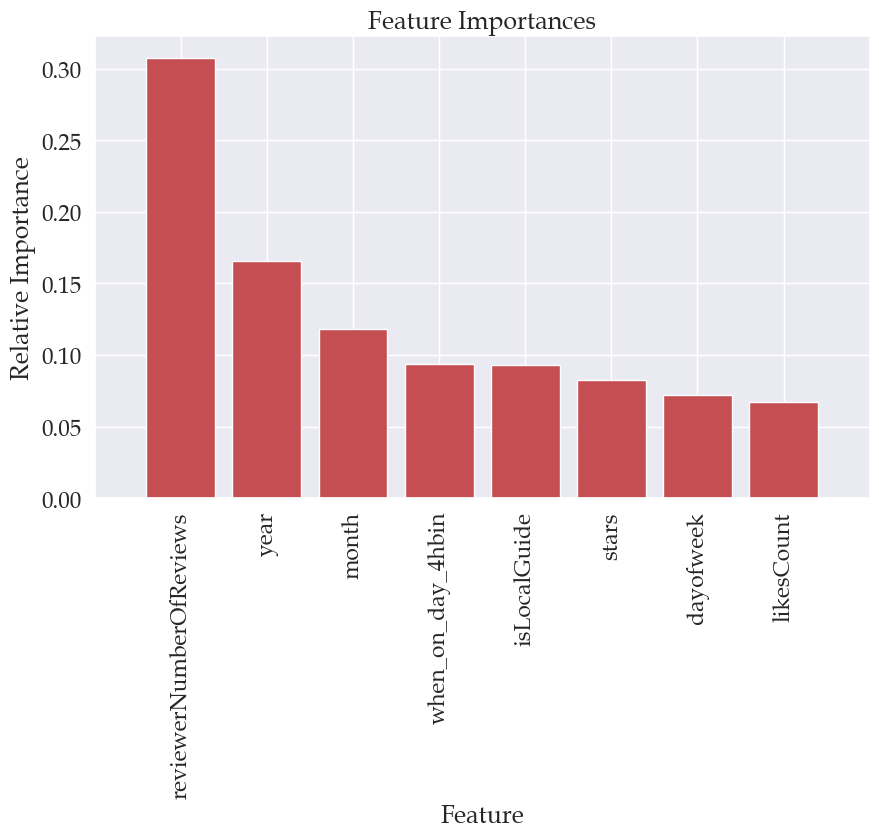

In [266]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Create a new dataframe with the extracted features

df = pd.read_csv("feature_enriched_tab.csv")

# print the col names
print(df.columns)
df = df[
    [
        "stars",
        "year",
        "month",
        "likesCount",
        "reviewerNumberOfReviews",
        "isLocalGuide",
        "dayofweek",
       # "elapsed_days",
        "when_on_day_4hbin",
        "label",
    ]
]

print(df.head())
df["label"] = (df["label"] == "real").astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("label", axis=1), df["label"], test_size=0.2, random_state=12
)

clf = DecisionTreeClassifier(random_state=1)

clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)

print(f"Decision tree accuracy: {score:.2f}")

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)

plt.ylabel("Relative Importance")
plt.xlabel("Feature")
plt.xlim([-1, X_train.shape[1]])
plt.show()


## Bild: Feature Generierung

1. Feature Extrahieren über Pretrained ResNet-18 Architektur und in Dataframe abspeichern.


In [3]:
df = pd.read_csv("feature_enriched_tab.csv")
image_urls = df["reviewImageUrls/0"]

In [4]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

# Load the pre-trained ResNet-18 model
resnet = models.resnet18(pretrained=True)
# Remove the last fully connected layer
modules = list(resnet.children())[:-1]
resnet = torch.nn.Sequential(*modules)
# Set the model to evaluation mode
resnet.eval()

# Define a function to extract features for a single image
def extract_image_features(image_url):
    # Load image and preprocess
    img = Image.open(requests.get(image_url, stream=True).raw)
    img = transforms.ToTensor()(img)
    img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)
    img = img.unsqueeze(0)

    # Extract features
    with torch.no_grad():
        features = resnet(img)
        features = features.squeeze().numpy()

    return features

c:\Users\michi\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\michi\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
import requests
import os
counter = 0
feature_vectors = []
for image_url in image_urls:
    try:
        counter += 1
        print(f'{counter}:\tExtracting features from {image_url}')
        features = extract_image_features(image_url)
    except:
        print(f'Error extracting features from {image_url}. Replaces with NaN.')
        features = np.full((512,), np.nan)
    feature_vectors.append(features)

# Create a new DataFrame with the extracted features
feature_df = pd.DataFrame(feature_vectors, columns=[f'feature_{i}' for i in range(512)])


Extracting features from https://raw.githubusercontent.com/MichaelSeitz98/seminararbeit_review_detection/main/02_Images/fake_image_url_0/0_ChZDSUhNMG9nS0VJQ0FnSURJanBQb1pBEAE_fake_reviewImageUrls_0.png
Extracting features from https://raw.githubusercontent.com/MichaelSeitz98/seminararbeit_review_detection/main/02_Images/fake_image_url_0/1_ChdDSUhNMG9nS0VJQ0FnSUNZLWRHY3VRRRAB_fake_reviewImageUrls_0.png
Extracting features from https://raw.githubusercontent.com/MichaelSeitz98/seminararbeit_review_detection/main/02_Images/fake_image_url_0/2_ChdDSUhNMG9nS0VJQ0FnSUNtc04zQXNRRRAB_fake_reviewImageUrls_0.png
Extracting features from https://raw.githubusercontent.com/MichaelSeitz98/seminararbeit_review_detection/main/02_Images/fake_image_url_0/3_ChZDSUhNMG9nS0VJQ0FnSUNvb05hU1pREAE_fake_reviewImageUrls_0.png
Extracting features from https://raw.githubusercontent.com/MichaelSeitz98/seminararbeit_review_detection/main/02_Images/fake_image_url_0/4_ChZDSUhNMG9nS0VJQ0FnSUQyazc3ZE53EAE_fake_reviewImag

In [10]:
new_df = pd.concat([df, feature_df], axis=1)
print("added features to the original dataset.")

print(new_df.iloc[0])
new_df.to_csv('feature_enriched_tab_img.csv', index=False)
new_df.to_excel('feature_enriched_tab_img.xlsx', index=False)

added features to the original dataset.
label                                                                                                                                                                                                                                                                                       fake
reviewId                                                                                                                                                                                                                                                    ChZDSUhNMG9nS0VJQ0FnSURJanBQb1pBEAEF
placeId                                                                                                                                                                                                                                                              ChIJ-9sjCNIKIocRl6FxNDni4UQ
reviewUrl                                                                                    

## Text: Feature Generierung

1. Feature extrahieren über PNLP Paket, wie z.B: lenth, adverb, Großklein, Rechtschriebung, Smiley-Nutzung usw... wie bei Peter


## Exkurs: Eigenen Img-Klassifikator trainiert und ausgwertet


Bilder für Training vorberieten und


In [ ]:
df = pd.read_csv("train_weitere_forschung_ohne_base.csv")

df = df.sample(n=500, random_state=9)
# df = df.sample(n=1000, random_state=42)
df = df.sort_index()

for index, row in df.iterrows():
    if index < 0:
        print(f"Index {index} schon heruntergeladen, skipped ..")
        continue
    for i in range(2):
        if not pd.isna(row[f"reviewImageUrls/{i}"]):
            print(f"Downloading image for {index}...")
            url = row[f"reviewImageUrls/{i}"]
            filename = f"{url.split('/')[-1]}.png"
            path = os.path.join("02_Images", "train", "real", filename)
            if not os.path.exists(path):
                try:
                    urllib.request.urlretrieve(url, path)
                except:
                    print(f"Error with {url}")

print("Done with downloading real images for training set.")


Start Umsetzung mit FASTAI visual Learning als Classifizierung Problem (AUF COLAB!)


In [ ]:
df = pd.read_csv("base_keywords_sentiment_reduced.csv")
print(df.shape)

df_all = pd.read_csv("01_Data/raw_data/dataset_weitere_forschung.csv")
print(df_all.shape)

df_all = df_all[
    [
        "text",
        "reviewId",
        "url",
        "placeId",
        "categoryName",
        "stars",
        "title",
        "reviewImageUrls/0",
        "reviewImageUrls/1",
        "reviewImageUrls/2",
        "reviewImageUrls/3",
        "reviewImageUrls/4",
        "reviewImageUrls/5",
        "genre",
    ]
]
df_all = df_all[df_all["reviewImageUrls/0"].notna()]
print(df_all.shape)
df_all = df_all[~df_all["reviewId"].isin(df["reviewId"])]
print(df_all.shape)
print(df_all.columns)

image_urls_cols = [
    "reviewImageUrls/0",
    "reviewImageUrls/1",
    "reviewImageUrls/2",
    "reviewImageUrls/3",
    "reviewImageUrls/4",
    "reviewImageUrls/5",
]
for col in image_urls_cols:
    print(f"Processing col {col}")
    df_all[col] = df_all[col].str.replace("=w150-h150-k-no-p", "=w256-h256-p-k-no")

print(df_all.shape)

# df_all.to_csv('train_weitere_forschung_ohne_base.csv', index=False)
# df_all.to_excel('train_weitere_forschung_ohne_base.xlsx', index=False)


Hier nur die Auswertung. Training in colab.ipynb Notebook.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from matplotlib import colors

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams["font.family"] = "Book Antiqua"

df = pd.read_csv("base_fake_real_imgcls_pred.csv")

y_true = df["label"]
y_pred = df["prediction_0"]

accuracy = accuracy_score(y_true, y_pred)
recall = classification_report(y_true, y_pred, output_dict=True)["weighted avg"][
    "recall"
]
precision = classification_report(y_true, y_pred, output_dict=True)["weighted avg"][
    "precision"
]
f1_score = classification_report(y_true, y_pred, output_dict=True)["weighted avg"][
    "f1-score"
]

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1_score:.4f}")

cmap = colors.ListedColormap(["#FFE5E4", "#D7F3D9"])

labels = y_true.unique()
fig, ax = plt.subplots(figsize=(5, 2.5))

cm = confusion_matrix(y_true, y_pred, labels=labels)


# Plot confusion matrix with custom colors
sns.heatmap(
    cm,
    annot=True,
    cmap=cmap,
    fmt="g",
    xticklabels=labels,
    yticklabels=labels,
    cbar=False,
)
plt.xlabel("Vorhersage")
plt.ylabel("Tatsächlich")

plt.savefig("confusion_matrix_green_red.svg", format="svg", bbox_inches="tight")
